In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# **Load Dataset**

In [92]:
def run_laptop_price_prediction():
    """
    Executes the full machine learning pipeline for laptop price prediction.
    Steps: Load, Preprocess, Split, Train, Predict, Evaluate, and Visualize.
    """
    print("--- Starting Laptop Price Prediction Pipeline ---")

    # ==============================================================================
    # Step 2: Load Dataset
    # ==============================================================================
    try:
        # Load the dataset, trying 'latin1' encoding based on project documentation
        df = pd.read_csv('/content/laptop_prices.csv', encoding='latin1')
    except Exception:
        # Fallback to standard reading if 'latin1' fails
        df = pd.read_csv('laptop_prices.csv')

    print(f"\nStep 2: Dataset loaded successfully with {df.shape[0]} rows.")

    # Initial Data Cleaning and Feature Engineering (Crucial for preprocessing)
    # Clean and convert 'Ram' and 'Weight'
    df['Ram (GB)'] = df['Ram'].astype(int)
    df['Weight (kg)'] = df['Weight'].apply(lambda x: float(str(x).replace('kg', '').strip()))

    # Calculate Total Storage
    df['PrimaryStorage_GB'] = df['PrimaryStorage'].astype(int)
    df['SecondaryStorage_GB'] = df['SecondaryStorage'].astype(int)
    df['TotalStorage_GB'] = df['PrimaryStorage_GB'] + df['SecondaryStorage_GB']

    # Clean 'CPU_freq' and calculate 'PPI' (Pixels Per Inch)
    df['CPU_freq'] = pd.to_numeric(df['CPU_freq'], errors='coerce')
    df['PPI'] = (((df['ScreenW']**2) + (df['ScreenH']**2))**0.5) / df['Inches']

    # Simplify 'OS' column for better encoding
    def simplify_os(os):
        if os in ['Windows 10', 'macOS']: return os
        elif os in ['No OS', 'Linux', 'Chrome OS']: return 'Other/Non-Windows'
        else: return 'Other/Non-Windows'
    df['OS_Simplified'] = df['OS'].apply(simplify_os)

    # Log-transform the target variable (Price)
    df['Log_Price_euros'] = np.log(df['Price_euros'])

    # ==============================================================================
    # Step 3: Data Preprocessing
    # ==============================================================================
    print("\nStep 3: Data Preprocessing...")

    # 3a. Handle Missing Values (dropping rows with NaN after numeric conversion)
    initial_rows = df.shape[0]
    df.dropna(subset=['CPU_freq', 'PPI'], inplace=True)
    print(f"  - Dropped {initial_rows - df.shape[0]} rows with missing key values.")

    # 3c. Feature Selection (Define X and y)
    features = [
        'Company', 'TypeName', 'Ram (GB)', 'Weight (kg)', 'Touchscreen',
        'IPSpanel', 'RetinaDisplay', 'CPU_company', 'CPU_freq', 'GPU_company',
        'PrimaryStorageType', 'SecondaryStorageType', 'TotalStorage_GB', 'OS_Simplified', 'PPI'
    ]
    X = df[features]
    y = df['Log_Price_euros'] # Target is log-transformed price

    # 3b. Convert Categorical Data to Numerical (One-Hot Encoding)
    categorical_features = X.select_dtypes(include='object').columns

    # Create a Column Transformer to apply One-Hot Encoding to categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )

    # Apply the transformation
    X_processed = preprocessor.fit_transform(X)
    print(f"  - Categorical features encoded. Final feature count: {X_processed.shape[1]}")


    # ==============================================================================
    # Step 4: Train-Test Split
    # ==============================================================================
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, test_size=0.2, random_state=42
    )
    print(f"\nStep 4: Data Split completed.")
    print(f"  - Training set size: {X_train.shape[0]} samples.")
    print(f"  - Testing set size: {X_test.shape[0]} samples.")

    # ==============================================================================
    # Step 5: Train the Model (Linear Regression)
    # ==============================================================================
    model = LinearRegression()
    model.fit(X_train, y_train)
    print("\nStep 5: Linear Regression Model trained successfully.")

    # ==============================================================================
    # Step 6: Make Predictions
    # ==============================================================================
    y_pred_log = model.predict(X_test)

    # Inverse transform predictions and test target to original Euros scale
    y_pred_euros = np.exp(y_pred_log)
    y_test_euros = np.exp(y_test)
    print("\nStep 6: Predictions made on the test set and inverse-transformed to Euros.")

    # ==============================================================================
    # Step 7: Evaluate the Model (MSE and R²)
    # ==============================================================================
    r2 = r2_score(y_test_euros, y_pred_euros)
    mse = mean_squared_error(y_test_euros, y_pred_euros)
    rmse = np.sqrt(mse)

    print("\nStep 7: Model Evaluation (Metrics on original Euros scale)")
    print(f"  - R-squared (R²): {r2:.4f}")
    print(f"  - Mean Squared Error (MSE): {mse:.2f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f} (Average prediction error in Euros)")

    # ==============================================================================
    # Step 8: Visualize Results (Actual vs. Predicted)
    # ==============================================================================

    plt.figure(figsize=(10, 6))

    # Scatter plot of Actual vs. Predicted values
    plt.scatter(y_test_euros, y_pred_euros, alpha=0.6, color='#1f77b4', label='Predicted Points')

    # Plot the perfect prediction line (y=x)
    min_val = min(y_test_euros.min(), y_pred_euros.min())
    max_val = max(y_test_euros.max(), y_pred_euros.max())
    plt.plot(
        [min_val, max_val], [min_val, max_val],
        color='#ff7f0e', linestyle='--', linewidth=2, label='Perfect Prediction ($y=x$)'
    )

    plt.title('Step 8: Actual vs. Predicted Laptop Prices', fontsize=14)
    plt.xlabel('Actual Price (€)', fontsize=12)
    plt.ylabel('Predicted Price (€)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.savefig('actual_vs_predicted_prices_final.png')
    # plt.show() # Uncomment to display plot in a local environment

    print("\nStep 8: Visualization completed. Plot saved as 'actual_vs_predicted_prices_final.png'.")
    print("--- Pipeline Finished Successfully ---")

In [93]:
# Step 3: Data Preprocessing
# ==============================================================================
print("\nStep 3: Data Preprocessing...")

# 3a. Handle Missing Values (dropping rows with NaN after numeric conversion)
initial_rows = df.shape[0]
df.dropna(subset=['CPU_freq', 'PPI'], inplace=True)
print(f"  - Dropped {initial_rows - df.shape[0]} rows with missing key values.")

# 3c. Feature Selection (Define X and y)
features = [
    'Company', 'TypeName', 'Ram (GB)', 'Weight (kg)', 'Touchscreen',
    'IPSpanel', 'RetinaDisplay', 'CPU_company', 'CPU_freq', 'GPU_company',
    'PrimaryStorageType', 'SecondaryStorageType', 'TotalStorage_GB', 'OS_Simplified', 'PPI'
]
X = df[features]
y = df['Log_Price_euros'] # Target is log-transformed price

# 3b. Convert Categorical Data to Numerical (One-Hot Encoding)
categorical_features = X.select_dtypes(include='object').columns

# Create a Column Transformer to apply One-Hot Encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Apply the transformation
X_processed = preprocessor.fit_transform(X)
print(f"  - Categorical features encoded. Final feature count: {X_processed.shape[1]}")


Step 3: Data Preprocessing...
  - Dropped 0 rows with missing key values.
  - Categorical features encoded. Final feature count: 58


In [94]:
# Step 4: Train-Test Split
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)
print(f"\nStep 4: Data Split completed.")
print(f"  - Training set size: {X_train.shape[0]} samples.")
print(f"  - Testing set size: {X_test.shape[0]} samples.")


Step 4: Data Split completed.
  - Training set size: 1020 samples.
  - Testing set size: 255 samples.


In [95]:
# Step 5: Train the Model (Linear Regression)
# ==============================================================================
model = LinearRegression()
model.fit(X_train, y_train)
print("\nStep 5: Linear Regression Model trained successfully.")


Step 5: Linear Regression Model trained successfully.


In [96]:
# Step 6: Make Predictions
# ==============================================================================
y_pred_log = model.predict(X_test)

# Inverse transform predictions and test target to original Euros scale
y_pred_euros = np.exp(y_pred_log)
y_test_euros = np.exp(y_test)
print("\nStep 6: Predictions made on the test set and inverse-transformed to Euros.")


Step 6: Predictions made on the test set and inverse-transformed to Euros.


In [97]:
# Step 7: Evaluate the Model (MSE and R²)
# ==============================================================================
r2 = r2_score(y_test_euros, y_pred_euros)
mse = mean_squared_error(y_test_euros, y_pred_euros)
rmse = np.sqrt(mse)

print("\nStep 7: Model Evaluation (Metrics on original Euros scale)")
print(f"  - R-squared (R²): {r2:.4f}")
print(f"  - Mean Squared Error (MSE): {mse:.2f}")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f} (Average prediction error in Euros)")


Step 7: Model Evaluation (Metrics on original Euros scale)
  - R-squared (R²): 0.7466
  - Mean Squared Error (MSE): 125770.29
  - Root Mean Squared Error (RMSE): 354.64 (Average prediction error in Euros)



Step 8: Visualization completed. Plot saved as 'actual_vs_predicted_prices_final.png'.
--- Pipeline Finished Successfully ---


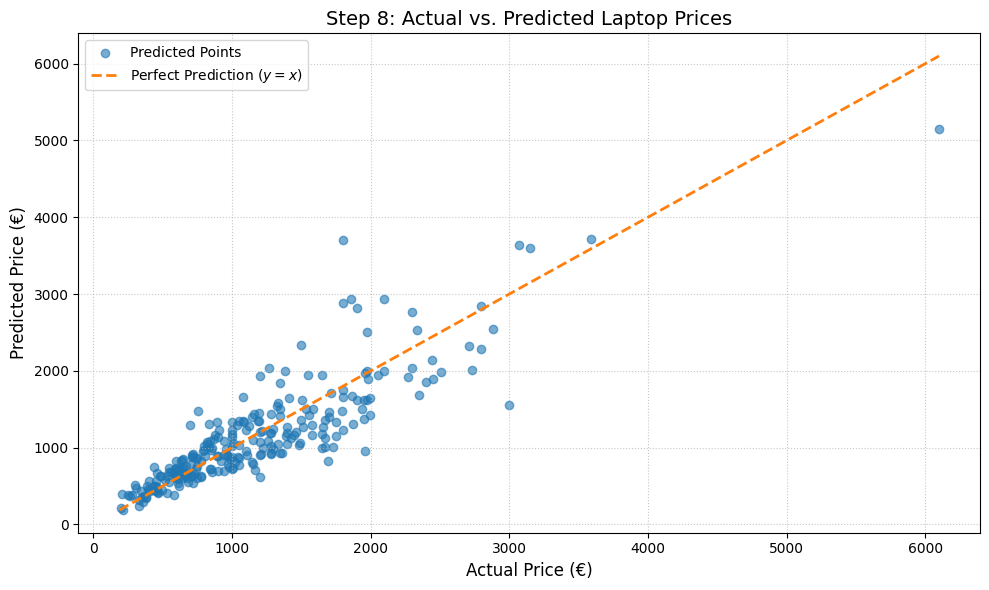

In [98]:
# Step 8: Visualize Results (Actual vs. Predicted)
# ==============================================================================

plt.figure(figsize=(10, 6))

# Scatter plot of Actual vs. Predicted values
plt.scatter(y_test_euros, y_pred_euros, alpha=0.6, color='#1f77b4', label='Predicted Points')

# Plot the perfect prediction line (y=x)
min_val = min(y_test_euros.min(), y_pred_euros.min())
max_val = max(y_test_euros.max(), y_pred_euros.max())
plt.plot(
    [min_val, max_val], [min_val, max_val],
    color='#ff7f0e', linestyle='--', linewidth=2, label='Perfect Prediction ($y=x$)'
)

plt.title('Step 8: Actual vs. Predicted Laptop Prices', fontsize=14)
plt.xlabel('Actual Price (€)', fontsize=12)
plt.ylabel('Predicted Price (€)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.savefig('actual_vs_predicted_prices_final.png')
# plt.show() # Uncomment to display plot in a local environment

print("\nStep 8: Visualization completed. Plot saved as 'actual_vs_predicted_prices_final.png'.")
print("--- Pipeline Finished Successfully ---")

# Remove the redundant function call
# if __name__ == '__main__':
#     run_laptop_price_prediction()

--- Starting Laptop Price Prediction Pipeline ---

Step 2: Dataset loaded successfully with 1275 rows.

Step 3: Data Preprocessing...
  - Dropped 0 rows with missing key values.
  - Categorical features encoded. Final feature count: 54

Step 4: Data Split completed.
  - Training set size: 1020 samples.
  - Testing set size: 255 samples.

Step 5: Linear Regression Model trained successfully.

Step 6: Predictions made on the test set and inverse-transformed to Euros.

Step 7: Model Evaluation (Metrics on original Euros scale)
  - R-squared (R²): 0.7264
  - Mean Squared Error (MSE): 135799.84
  - Root Mean Squared Error (RMSE): 368.51 (Average prediction error in Euros)

Step 8: Visualization completed. Plot saved as 'actual_vs_predicted_prices_final.png'.
--- Pipeline Finished Successfully ---


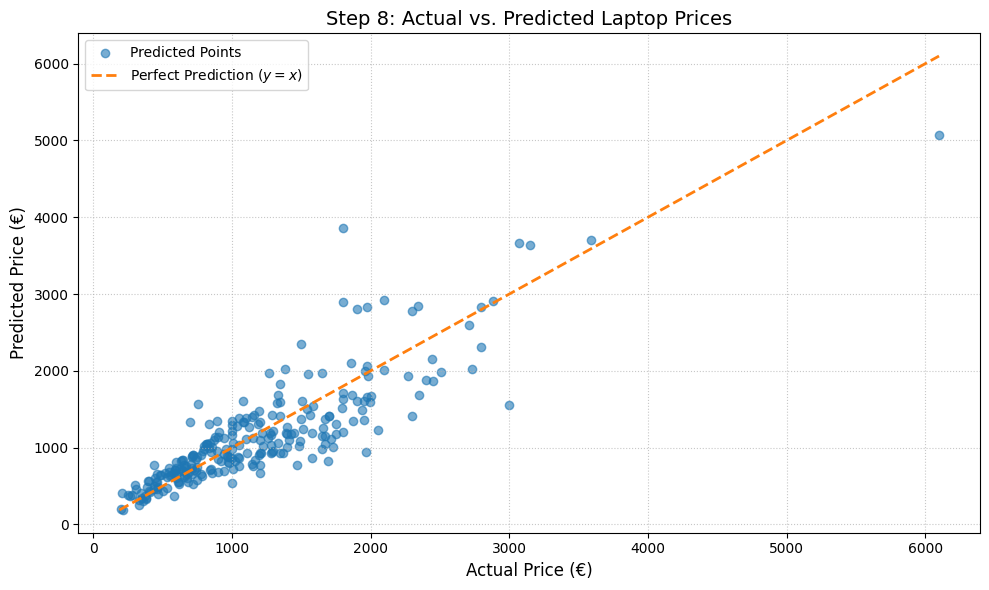

In [99]:
# Execute the full pipeline
run_laptop_price_prediction()

# **Model Evaluation**

In [100]:
# Step 6: Evaluate the Model
# ==============================================================================
y_pred = model.predict(X_test)

# Inverse transform the predicted and actual values if the target was transformed
y_test_orig = np.exp(y_test)        # Assuming log-transformed
y_pred_orig = np.exp(y_pred)        # Assuming log-transformed

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred_orig)

print("\nStep 6: Model Evaluation Results:")
print(f"  - Mean Squared Error (MSE): {mse:.2f}")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  - R-squared (R2): {r2:.2f}")


Step 6: Model Evaluation Results:
  - Mean Squared Error (MSE): 125770.29
  - Root Mean Squared Error (RMSE): 354.64
  - R-squared (R2): 0.75


# **Visualization of Results**

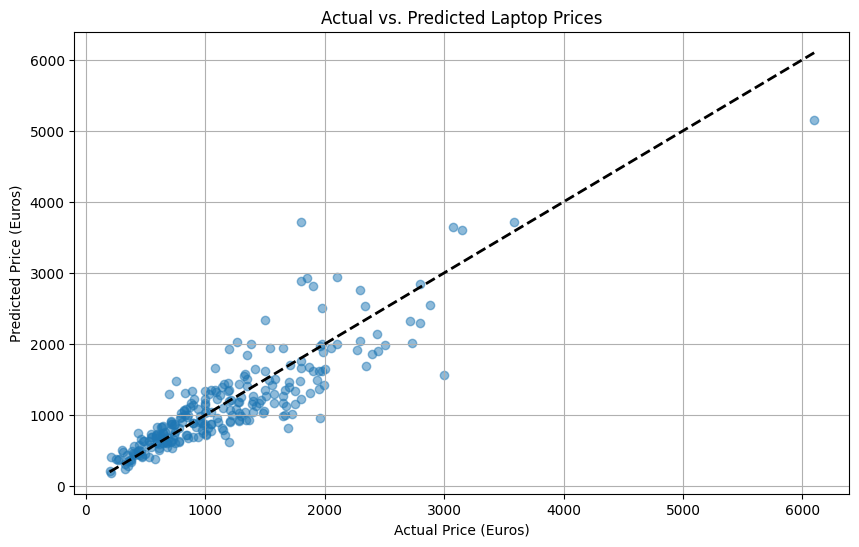


Step 7: Visualization complete.


In [101]:
# Step 7: Visualize Results (Actual vs. Predicted Prices)
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'k--', lw=2)
plt.xlabel("Actual Price (Euros)")
plt.ylabel("Predicted Price (Euros)")
plt.title("Actual vs. Predicted Laptop Prices")
plt.grid(True)
plt.show()

print("\nStep 7: Visualization complete.")

# **Finish task**

In [102]:
print("\n--- Laptop Price Prediction Pipeline Finished ---")


--- Laptop Price Prediction Pipeline Finished ---
